# Mapping and clustering analysis for NI tests 

### Requirements and dependencies

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator


### Specimen informations + Results path

In [2]:
# Sample 1
sampleNames = ['Ni_SiC']
file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\Ni_SiC\MTS_example1_25x25.xls")]
sheet_name = 'Sample'

# Sample 2
sampleNames = ['HSS-Steel_Carbides']
file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\HSS_Steel_Carbides\MTS_example1_25x25_flower.xls")]
sheet_name = 'Sample'

# Result directory
result_dir = Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results")


### Loading dataset and make mechanical properties dataframe

In [3]:
# Import data from Excel files
data_frames = []
for file_path in file_paths:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    data_frames.append(df)
data = pd.concat(data_frames, ignore_index=True)

# Merge first row (containing units) with the header
data.columns = [f"{col}_{unit}" if unit else col for col, unit in zip(data.columns, data.iloc[0])]
data = data.drop(index=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='ignore')

# Replace empty strings with NaN
data.replace("", np.nan, inplace=True)

# Remove colums Markers and Index Integer
data.drop(columns=[col for col in data.columns if 'Markers_nan' in col or 'Index_Integer' in col], inplace=True)

print(data.head())

   X Position_µm  Y Position_µm  MODULUS_GPa  HARDNESS_GPa
0              0              0      268.522        23.307
1              2              0      224.329         8.073
2              4              0      249.184         7.273
3              6              0      274.592         6.630
4              8              0      287.293         5.951


C:\Users\dmercier\AppData\Local\Temp\ipykernel_11952\2671100656.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Mapping analysis

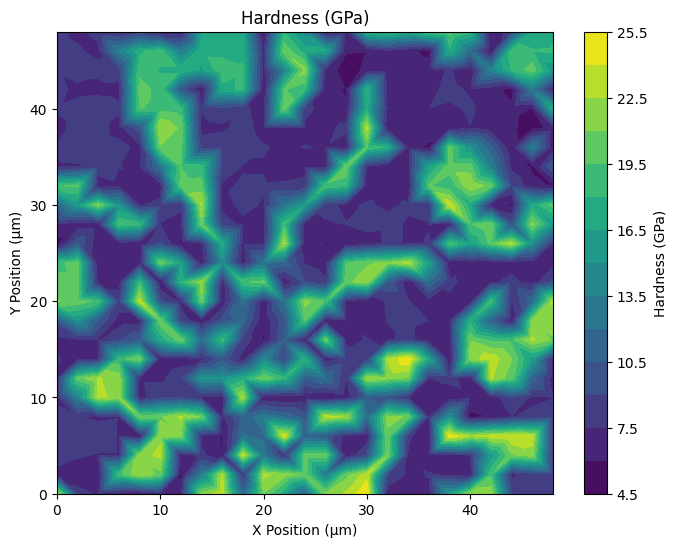

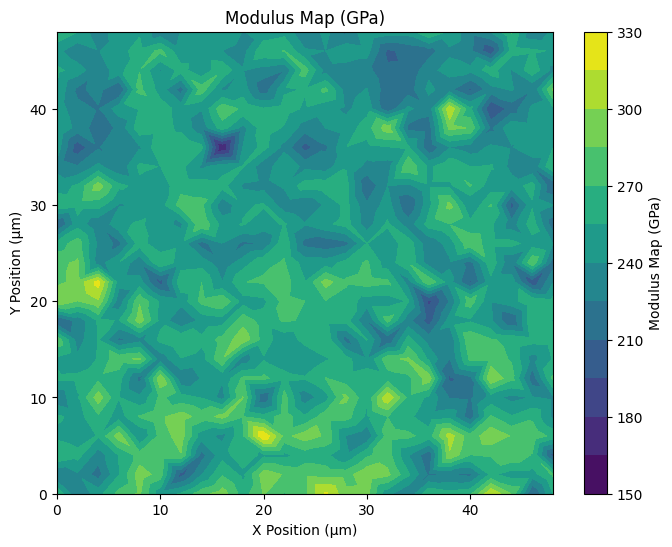

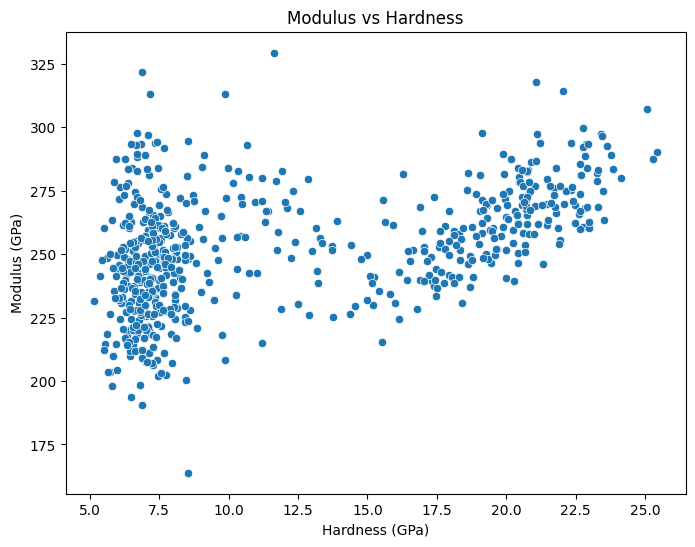

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


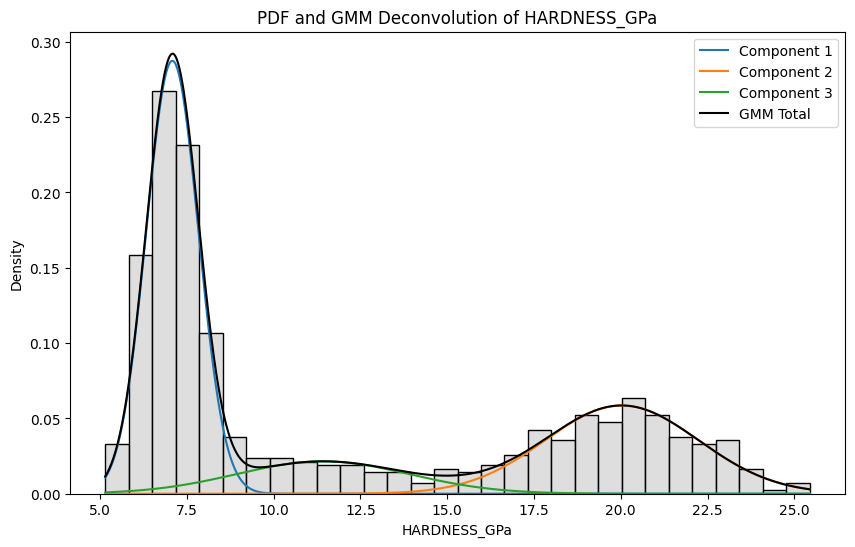

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


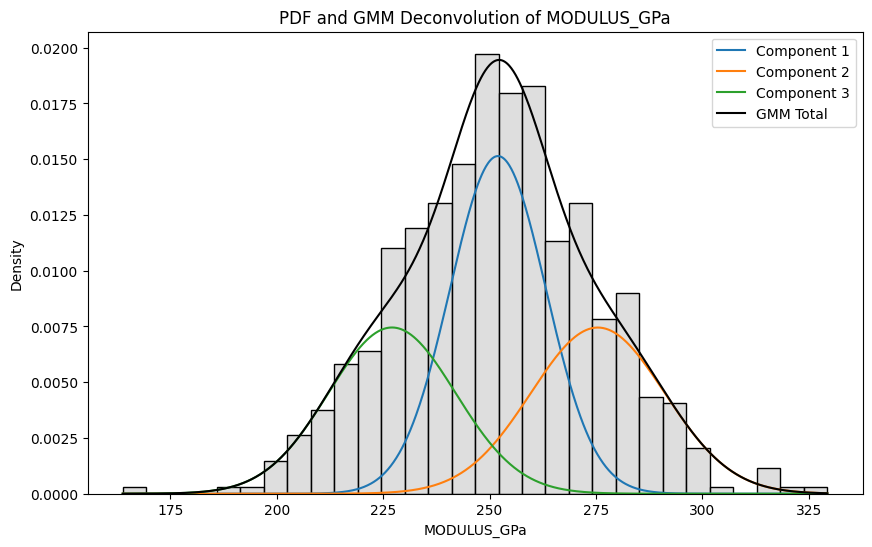

In [4]:
def plot_map(x, y, z, title, xlabel, ylabel, cmap='viridis', save_path=None):
    # Filter out non-finite values
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x, y, z = x[mask], y[mask], z[mask]
    
    plt.figure(figsize=(8, 6))
    plt.tricontourf(x, y, z, levels=14, cmap=cmap)
    plt.colorbar(label=title)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Plot Hardness map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['HARDNESS_GPa'], 
         title='Hardness (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         save_path='hardness_map.png')

# Plot Modulus map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['MODULUS_GPa'], 
         title='Modulus Map (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         save_path='modulus_map.png')

# Plot Modulus vs Hardness
plt.figure(figsize=(8, 6))
sns.scatterplot(y='MODULUS_GPa', x='HARDNESS_GPa', data=data)
plt.title('Modulus vs Hardness')
plt.ylabel('Modulus (GPa)')
plt.xlabel('Hardness (GPa)')
plt.savefig('modulus_vs_hardness.png')
plt.show()

# Plot Probability Density Function (PDF) of Hardness and Modulus + Deconvolution
def plot_pdf_with_deconvolution(data, column, n_components=3, save_path=None):
    plt.figure(figsize=(10, 6))
    
    # Plot histogram
    sns.histplot(data[column].dropna(), bins=30, kde=False, stat='density', color='lightgray', edgecolor='black')
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data[[column]].dropna())
    
    # Generate x values for plotting the GMM components
    x = np.linspace(data[column].min(), data[column].max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)
    pdf = np.exp(logprob)
    
    # Plot GMM components
    for i in range(n_components):
        plt.plot(x, responsibilities[:, i] * pdf, label=f'Component {i+1}')
    
    plt.plot(x, pdf, '-k', label='GMM Total')
    plt.title(f'PDF and GMM Deconvolution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

n_componentsVal = 3  # Adjust based on expected number of phases
# Plot PDF and GMM Deconvolution for Hardness
plot_pdf_with_deconvolution(data, 'HARDNESS_GPa', n_components=n_componentsVal, save_path='hardness_pdf_gmm.png')
# Plot PDF and GMM Deconvolution for Modulus
plot_pdf_with_deconvolution(data, 'MODULUS_GPa', n_components=n_componentsVal, save_path='modulus_pdf_gmm.png')

### Matrix correlation analysis

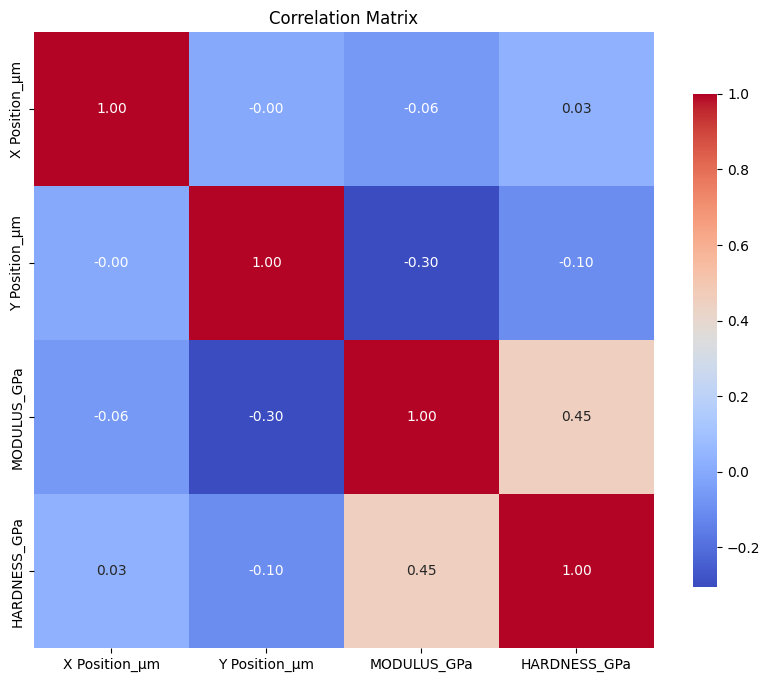

In [5]:
# Plot matrix correlation
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

### Clustering analysis - Number of clusters estimation

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\

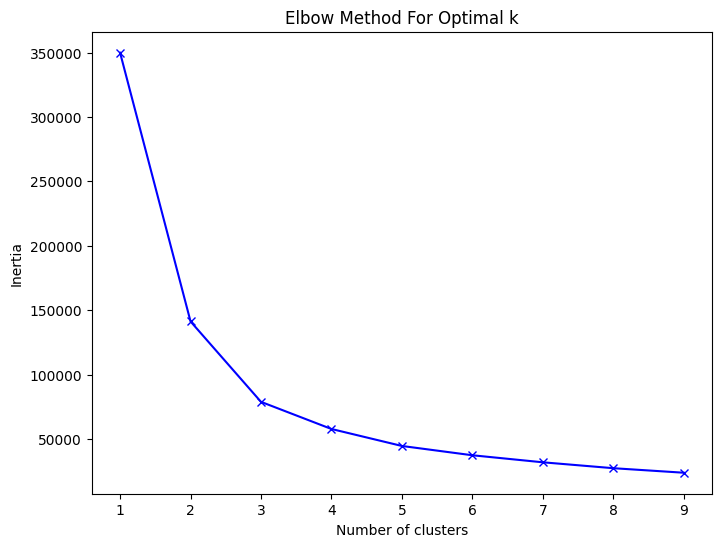

Optimal number of clusters: 3


In [6]:

# Determine optimal number of clusters using Elbow Method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow_method.png')
plt.show()

# Find the optimal number of clusters using KneeLocator
knee_locator = KneeLocator(K, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"Optimal number of clusters: {optimal_k}")

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)

### Clustering analysis - K-means clustering

   HARDNESS_GPa  MODULUS_GPa  Cluster
0        23.307      268.522        0
1         8.073      224.329        2
2         7.273      249.184        1
3         6.630      274.592        0
4         5.951      287.293        0


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


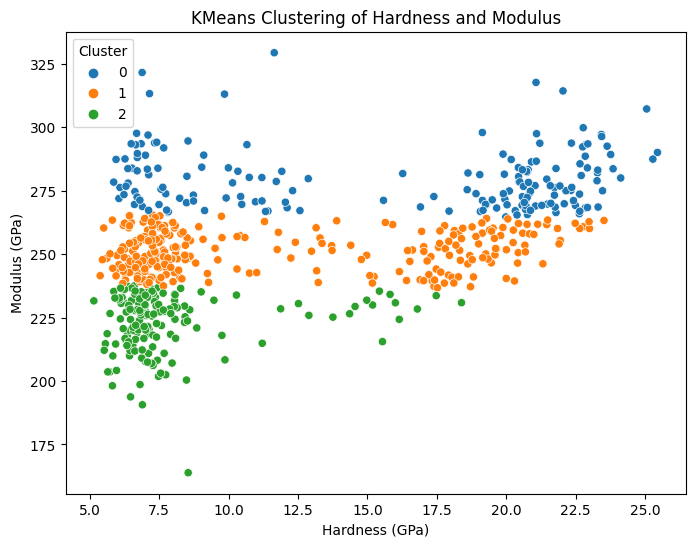

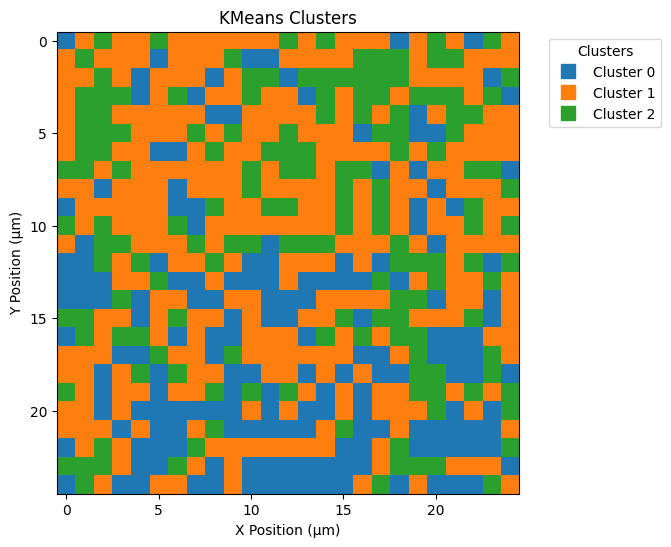

        HARDNESS_GPa                          MODULUS_GPa                      \
                mean       std    min     max        mean        std      min   
Cluster                                                                         
0          15.916960  6.582996  5.867  25.445  279.460764  11.829717  264.625   
1          11.598565  5.563095  5.380  23.520  251.278469   7.584072  236.720   
2           7.907220  2.638029  5.151  18.389  222.936855  11.326279  163.865   

                 Count  
             max count  
Cluster                 
0        329.307   174  
1        265.346   292  
2        237.432   159  
Cluster 0: 174 points, 27.84%
Cluster 1: 292 points, 46.72%
Cluster 2: 159 points, 25.44%


In [7]:
# Cluster the data using KMeans, or GMM...
method = 'KMeans' # 'GMM'

if method == 'KMeans':
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
elif method == 'GMM':
    kmeans = GaussianMixture(n_components=optimal_k, random_state=42)

data = data.dropna(subset=['HARDNESS_GPa', 'MODULUS_GPa']).reset_index(drop=True)

if method == 'KMeans':
    data['Cluster'] = kmeans.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])
elif method == 'GMM':
    data['Cluster'] = kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']]).predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])

data['Cluster'] = data['Cluster'].astype(int)
print(data[['HARDNESS_GPa', 'MODULUS_GPa', 'Cluster']].head())

# Plot clustered data using colors defined above
plt.figure(figsize=(8, 6))
sns.scatterplot(x='HARDNESS_GPa', y='MODULUS_GPa', hue='Cluster', palette=colors, data=data)
plt.title('KMeans Clustering of Hardness and Modulus')
plt.xlabel('Hardness (GPa)')
plt.ylabel('Modulus (GPa)')
plt.legend(title='Cluster')
plt.savefig('kmeans_clusters.png')
plt.show()

# Function to create a grid and plot square pixels
def plot_pixel_map(x, y, z, title, xlabel, ylabel, cluster_colors, save_path=None):
    # Create a pivot table to structure data into a grid
    grid_data = pd.DataFrame({'X': x, 'Y': y, 'Cluster': z})
    pivot = grid_data.pivot(index='Y', columns='X', values='Cluster')
    
    # Sort the grid to ensure proper alignment
    pivot = pivot.sort_index(ascending=False)  # Y-axis should be inverted for plotting
    
    # Create a colormap for clusters
    unique_clusters = np.unique(z)
    cluster_cmap = [cluster_colors[cluster] for cluster in unique_clusters]
    cmap = plt.matplotlib.colors.ListedColormap(cluster_cmap)
    
    # Plot the grid as square pixels
    plt.figure(figsize=(8, 6))
    plt.imshow(pivot, cmap=cmap, aspect='equal', interpolation='none')  # Square pixels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add a legend for clusters
    handles = [plt.Line2D([0], [0], marker='s', color=color, linestyle='', markersize=10, label=f'Cluster {cluster}')
               for cluster, color in zip(unique_clusters, cluster_cmap)]
    plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save with tight layout to include the legend
    plt.show()

# Create a colormap for clusters
cmap = {i: colors[i] for i in range(optimal_k)}
data['Cluster_Color'] = data['Cluster'].map(cmap)

# Plot clusters on spatial map with square pixels
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='KMeans Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
               cluster_colors=cmap, save_path='spatial_clusters_square_pixels.png')

# Print cluster statistics
cluster_stats = data.groupby('Cluster').agg({
    'HARDNESS_GPa': ['mean', 'std', 'min', 'max'],
    'MODULUS_GPa': ['mean', 'std', 'min', 'max'],
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

print(cluster_stats)

# Print clusters ratio in %
total_points = len(data)
for cluster in range(optimal_k):
    count = len(data[data['Cluster'] == cluster])
    ratio = (count / total_points) * 100
    print(f"Cluster {cluster}: {count} points, {ratio:.2f}%")


### All plots

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


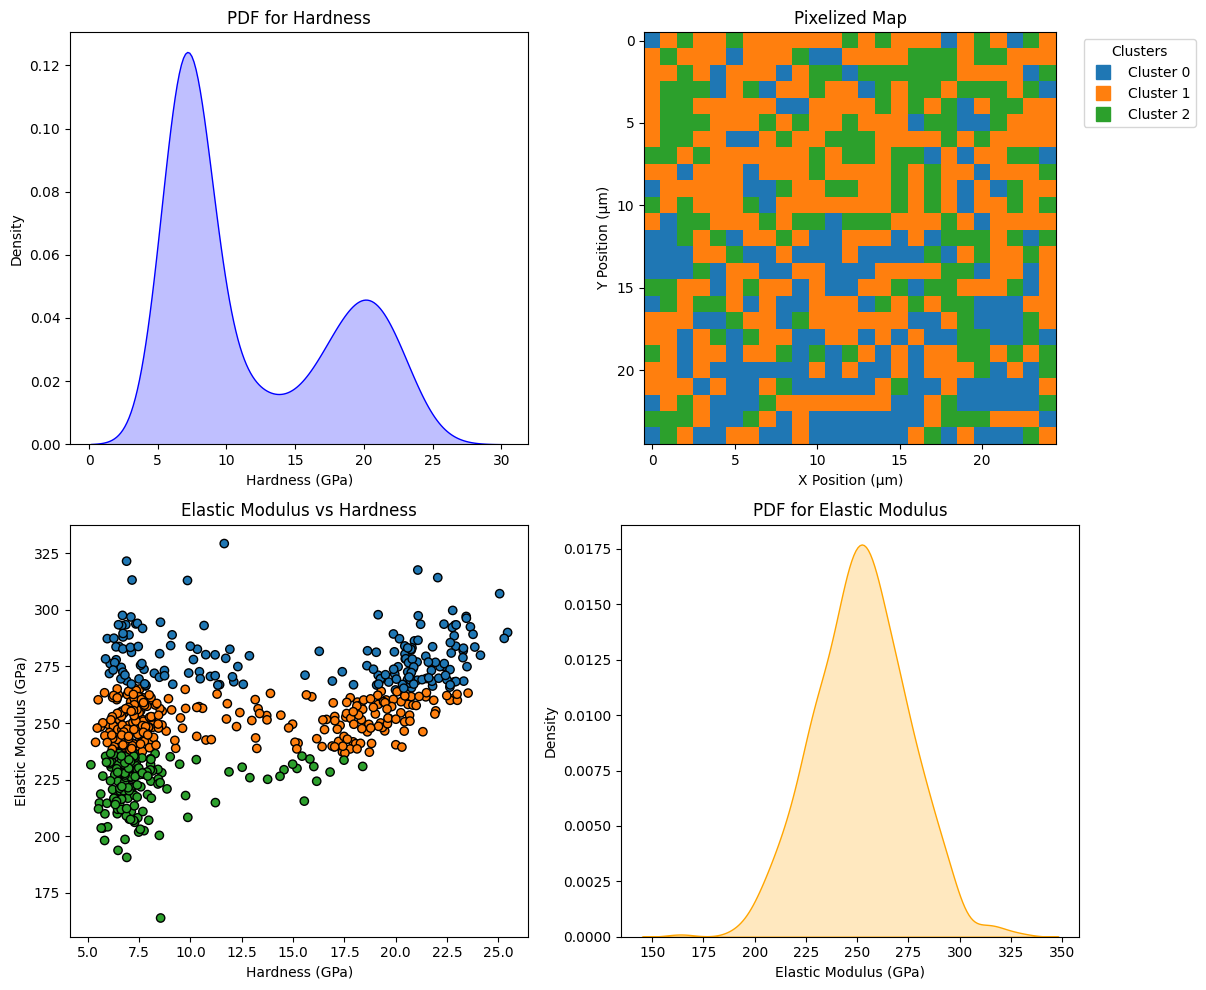

In [8]:
# Define the number of clusters
optimal_k = len(data['Cluster'].unique())

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)
cluster_cmap = ListedColormap(colors)

# Pivot data for pixelized map (handle duplicates by aggregating with pivot_table)
grid_data = data.pivot_table(
    index='Y Position_µm',
    columns='X Position_µm',
    values='Cluster',
    aggfunc='mean'  # You can use 'mean', 'median', or another aggregation function
)
grid_data = grid_data.sort_index(ascending=False)  # Ensure proper orientation

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top Left: PDF for Hardness
sns.kdeplot(data['HARDNESS_GPa'], ax=axes[0, 0], fill=True, color='blue')
axes[0, 0].set_title('PDF for Hardness')
axes[0, 0].set_xlabel('Hardness (GPa)')
axes[0, 0].set_ylabel('Density')

# Top Right: Pixelized Map
im = axes[0, 1].imshow(grid_data, cmap=cluster_cmap, aspect='equal', interpolation='none')
axes[0, 1].set_title('Pixelized Map')
axes[0, 1].set_xlabel('X Position (µm)')
axes[0, 1].set_ylabel('Y Position (µm)')
# Create discrete legend handles for clusters
unique_clusters = np.unique(grid_data[~np.isnan(grid_data)])  # Exclude NaN values
handles = [plt.Line2D([0], [0], marker='s', color=cluster_cmap(cluster / len(unique_clusters)), 
                      linestyle='', markersize=10, label=f'Cluster {int(cluster)}') 
           for cluster in unique_clusters]
# Add the discrete legend
axes[0, 1].legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottom Left: Elastic Modulus vs Hardness
axes[1, 0].scatter(data['HARDNESS_GPa'], data['MODULUS_GPa'], c=data['Cluster'], cmap=cluster_cmap, edgecolor='k')
axes[1, 0].set_title('Elastic Modulus vs Hardness')
axes[1, 0].set_xlabel('Hardness (GPa)')
axes[1, 0].set_ylabel('Elastic Modulus (GPa)')

# Bottom Right: PDF for Elastic Modulus
sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fill=True, color='orange')
axes[1, 1].set_title('PDF for Elastic Modulus')
axes[1, 1].set_xlabel('Elastic Modulus (GPa)')
axes[1, 1].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()